In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h3
from geopy.distance import geodesic

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from matplotlib.ticker import MultipleLocator

## Data Loading, Checking, further Data Preparation and Cleaning

In [41]:
data = pd.read_csv("../data/analytics_trip_data_clustering.csv")

In [42]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
# Korrekte Verwendung der describe-Methode
data.describe()

# Überprüfe auf NaN-Werte jeder Spalte
nan_info = data.isna().sum()
print(nan_info)

trip_id                          0
taxi_id                          0
trip_start_timestamp             0
trip_end_timestamp               0
trip_seconds                     0
trip_miles                       0
pickup_census_tract              0
dropoff_census_tract             0
pickup_community_area            0
dropoff_community_area           0
fare                             0
tips                             0
tolls                        15606
extras                           0
trip_total                       0
payment_type                     0
company                          0
pickup_centroid_location         0
dropoff_centroid_location        0
h3_res_4_pickup                  0
h3_res_4_dropoff                 0
h3_res_6_pickup                  0
h3_res_6_dropoff                 0
h3_res_8_pickup                  0
h3_res_8_dropoff                 0
h3_res_9_pickup                  0
h3_res_9_dropoff                 0
trip_middle_timestamp            0
price_per_mile      

In [43]:
data.drop(columns=['tolls'], inplace=True)
data.dropna(inplace=True)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47032 entries, 0 to 47032
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   trip_id                    47032 non-null  object 
 1   taxi_id                    47032 non-null  object 
 2   trip_start_timestamp       47032 non-null  object 
 3   trip_end_timestamp         47032 non-null  object 
 4   trip_seconds               47032 non-null  float64
 5   trip_miles                 47032 non-null  float64
 6   pickup_census_tract        47032 non-null  int64  
 7   dropoff_census_tract       47032 non-null  int64  
 8   pickup_community_area      47032 non-null  float64
 9   dropoff_community_area     47032 non-null  float64
 10  fare                       47032 non-null  float64
 11  tips                       47032 non-null  float64
 12  extras                     47032 non-null  float64
 13  trip_total                 47032 non-null  float64


In [45]:
data.head(1)

trip_id  \
0  a327275a2eae6039e8aef35159df16a004403523   

                                                                                                                            taxi_id  \
0  e56ed381a43f3b714beba8c05f52736bbc9e23bed8bf1d6d7a16c10205764c546be5bd53288f1af36d0704d106706a22a54d1f1585e4dce2b75368a0205278c9   

  trip_start_timestamp   trip_end_timestamp  trip_seconds  trip_miles  \
0  2018-01-01 00:15:00  2018-01-01 00:30:00         780.0         2.9   

   pickup_census_tract  dropoff_census_tract  pickup_community_area  \
0          17031830700           17031010702                    3.0   

   dropoff_community_area  fare  tips  extras  trip_total payment_type  \
0                     1.0  11.0   0.0     1.0        12.5  Credit Card   

    company            pickup_centroid_location  \
0  Sun Taxi  POINT (-87.6558787862 41.96581197)   

                  dropoff_centroid_location  h3_res_4_pickup h3_res_4_dropoff  \
0  POINT (-87.67016685690001 42.0096228806)  842664dffffffff  842664dffffffff   

   h3_res_6_pickup h3_res_6_dropoff  h3_res_8_pickup h3_res_8_dropoff  \
0  862664d8fffffff  862664d8fffffff  882664d897fffff  882664d8cdfffff   

   h3_res_9_pickup h3_res_9_dropoff trip_middle_timestamp  price_per_mile  \
0  892664d8973ffff  892664d8ccfffff   2018-01-01 00:22:30       11.344828   

   miles_per_hour                 date  temperature  precipitation  \
0       13.384615  2018-01-01 01:53:00   -18.333333            0.0   

              Game_End  sports_event_h3  sports_event_census_tract  \
0  2018-01-01 00:00:00              0.0                        0.0   

   poi_h3_res_8  poi_h3_res_6  poi_h3_res_4  poi_census_tract  
0          20.0         406.0          3470              19.0

In [46]:
data['trip_start_timestamp'] = pd.to_datetime(data['trip_start_timestamp'])
data['hour'] = data['trip_start_timestamp'].dt.hour
data['weekday'] = data['trip_start_timestamp'].dt.weekday
data['month'] = data['trip_start_timestamp'].dt.month
data['pick_from_sport'] = ((data['sports_event_h3'] != 0) | (data['sports_event_census_tract'] != 0)).astype(int)
data['pick_from_poi'] = ((data['poi_h3_res_8'] != 0) | (data['poi_census_tract'] != 0)).astype(int)

In [47]:
print(data['pick_from_sport'].sum())
print(data['pick_from_poi'].sum())
print(data['poi_h3_res_8'].describe())

4
46706
count    47032.000000
mean        44.542227
std         39.705866
min          0.000000
25%         11.000000
50%         48.000000
75%         53.000000
max        124.000000
Name: poi_h3_res_8, dtype: float64


Including sports event data does not seem to make much sense, as too few cab journeys can be linked to sports events. With the POI data it seems to be different, almost all trips can be linked to Resolution 8 with H3 data. However, this results in another problem, as there are more POIs in a polygon at resolution 8. It is therefore not always possible to say directly whether the journey was a journey towards a point of interest.

In [48]:
from haversine import haversine_vector, Unit
chicago_coords = (41.8781, -87.6298)

data[['pickup_longitude', 'pickup_latitude']] = data['pickup_centroid_location'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)').astype(float)
data[['dropoff_longitude', 'dropoff_latitude']] = data['dropoff_centroid_location'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)').astype(float)

pickup_coords = data[['pickup_latitude', 'pickup_longitude']].values
dropoff_coords = data[['dropoff_latitude', 'dropoff_longitude']].values

chicago_coords_array = np.array([chicago_coords] * len(data))

data['distance_to_chicago'] = haversine_vector(pickup_coords, chicago_coords_array, Unit.MILES)

data['distance_from_chicago'] = haversine_vector(dropoff_coords, chicago_coords_array, Unit.MILES)

data.head(5)

trip_id  \
0  a327275a2eae6039e8aef35159df16a004403523   
1  dceeed0c696adf610cbf8be575b6ad1557e24e4b   
2  12c6e02f7d25c503736dae233ce2281a815dc67a   
3  43cef1f706982c96e7ad2a5a1667a22c2724a804   
4  de17250f0acb7dc44e0b64d28b14778ddb4642b2   

                                                                                                                            taxi_id  \
0  e56ed381a43f3b714beba8c05f52736bbc9e23bed8bf1d6d7a16c10205764c546be5bd53288f1af36d0704d106706a22a54d1f1585e4dce2b75368a0205278c9   
1  91e0d0657e001b446de9a5de4277192d09fe857236bc29b1efb4b171a1480e8dd1429a28fb94dce3c2196fc42a4913b57c679a3f40f4477906a21aa078dcebb6   
2  28d27337bea07d811235348e9b25af937d110ac08ca576e50099ad02e5d1e0ede037b6c36e983918123eeec68b1610d6851965894f42d7758ee0fb726a8e03a3   
3  6b97148e5dec989c75f5183f6cbf6aac41d6232a4805fe7866410223bd2a329173a3cb43b2c3a470315a37a7ad2cb78a5f93d5c5ca7079b41ef031540c4c8c93   
4  6dda793bf125a4725cd96cbede2e75fe712d6a5b3570e87f40a5704d229dea72d4a750de3549106355967d99a8126d3af24bde097b4c3cd3ba829ac591ef2170   

  trip_start_timestamp   trip_end_timestamp  trip_seconds  trip_miles  \
0  2018-01-01 00:15:00  2018-01-01 00:30:00         780.0        2.90   
1  2018-01-01 00:15:00  2018-01-01 00:30:00         540.0        3.20   
2  2018-01-01 00:15:00  2018-01-01 00:30:00         486.0        4.55   
3  2018-01-01 00:15:00  2018-01-01 00:30:00         960.0        4.20   
4  2018-01-01 00:15:00  2018-01-01 00:30:00         795.0        5.00   

   pickup_census_tract  dropoff_census_tract  pickup_community_area  \
0          17031830700           17031010702                    3.0   
1          17031320400           17031600900                   32.0   
2          17031832900           17031839500                   28.0   
3          17031221300           17031062200                   22.0   
4          17031062200           17031010702                    6.0   

   dropoff_community_area   fare  tips  extras  trip_total payment_type  \
0                     1.0  11.00   0.0     1.0       12.50  Credit Card   
1                    60.0  11.00   0.0     0.0       11.00         Cash   
2                    35.0  13.50   0.0     0.0       13.50         Cash   
3                     6.0  14.50   0.0     0.0       14.50         Cash   
4                     1.0  15.25   0.0     1.0       16.25         Cash   

                     company                  pickup_centroid_location  \
0                   Sun Taxi        POINT (-87.6558787862 41.96581197)   
1    Choice Taxi Association      POINT (-87.6251921424 41.8788655841)   
2  Chicago Carriage Cab Corp       POINT (-87.6635175498 41.874005383)   
3                 Globe Taxi  POINT (-87.69915534320002 41.9227606205)   
4               City Service      POINT (-87.6559981815 41.9442266014)   

                  dropoff_centroid_location  h3_res_4_pickup h3_res_4_dropoff  \
0  POINT (-87.67016685690001 42.0096228806)  842664dffffffff  842664dffffffff   
1      POINT (-87.6487879519 41.8361501547)  842664dffffffff  842664dffffffff   
2      POINT (-87.6186777673 41.8351179863)  842664dffffffff  842664dffffffff   
3      POINT (-87.6559981815 41.9442266014)  842664dffffffff  842664dffffffff   
4  POINT (-87.67016685690001 42.0096228806)  842664dffffffff  842664dffffffff   

   h3_res_6_pickup h3_res_6_dropoff  h3_res_8_pickup h3_res_8_dropoff  \
0  862664d8fffffff  862664d8fffffff  882664d897fffff  882664d8cdfffff   
1  862664c1fffffff  862664cf7ffffff  882664c1a9fffff  882664cf01fffff   
2  862664cafffffff  862664cf7ffffff  882664ca91fffff  882664cf53fffff   
3  862664ca7ffffff  862664c17ffffff  882664ca11fffff  882664c163fffff   
4  862664c17ffffff  862664d8fffffff  882664c163fffff  882664d8cdfffff   

   h3_res_9_pickup h3_res_9_dropoff trip_middle_timestamp  price_per_mile  \
0  892664d8973ffff  892664d8ccfffff   2018-01-01 00:22:30       11.344828   
1  892664c1a87ffff  892664cf017ffff   2018-01-01 00:22:30       11.000000   
2  892664ca913ffff  892

## Feature Creating & Selection

In [49]:
features = ["trip_seconds", "price_per_mile", "miles_per_hour", "trip_miles", "fare", "hour", "weekday", "month","temperature", "distance_to_chicago", "distance_from_chicago"]

In [50]:
Cluster_all = data[features]

In [51]:
Cluster_all.describe()

trip_seconds  price_per_mile  miles_per_hour    trip_miles  \
count  47032.000000    47032.000000    47032.000000  47032.000000   
mean    1034.760121       18.040255       19.090627      5.683299   
std      666.087882       11.492073        8.896052      4.772793   
min       61.000000        0.010000        1.021277      0.170000   
25%      599.000000       10.000000       12.800000      2.300000   
50%      874.000000       14.500000       17.132644      4.100000   
75%     1310.000000       22.250000       24.315789      7.400000   
max     7179.000000      560.240000       49.973475     47.100000   

               fare          hour       weekday         month   temperature  \
count  47032.000000  47032.000000  47032.000000  47032.000000  47032.000000   
mean      17.870766     13.042524      2.990411      2.342001      0.630741   
std       11.422761      6.740091      1.977584      1.040830      7.043087   
min        0.010000      0.000000      0.000000      1.000000    -22.777778   
25%       10.000000      8.000000      1.000000      1.000000     -2.777778   
50%       14.500000     14.000000      3.000000      2.000000      1.666667   
75%       22.250000     19.000000      5.000000      3.000000      5.000000   
max      560.240000     23.000000      6.000000      4.000000     23.333333   

       distance_to_chicago  distance_from_chicago  
count         47032.000000           47032.000000  
mean              4.517997               4.859682  
std               4.547715               3.277594  
min               0.242878               0.242878  
25%               1.496572               2.878049  
50%               2.878049               4.716284  
75%               6.206846               6.206846  
max              16.207510              16.207510

In [52]:
#Cluster_all_ohe = pd.get_dummies(Cluster_all, columns=["hour", "weekday", "month"])
def one_hot_encoding(df, list):
    for element in list:
        one_hot_encoded = pd.get_dummies(df[element], prefix=element)

        one_hot_encoded = one_hot_encoded.astype(int)
        
        # Concatenate the one-hot encoded features with the original DataFrame
        df = pd.concat([df, one_hot_encoded], axis=1)

        # Drop the original column after one-hot encoding
        df = df.drop(columns=[element])
    return  df

Cluster_all_ohe = one_hot_encoding(Cluster_all, ["hour", "weekday", "month"])


In [53]:
Cluster_all_ohe.head(1)

trip_seconds  price_per_mile  miles_per_hour  trip_miles  fare  \
0         780.0       11.344828       13.384615         2.9  11.0   

   temperature  distance_to_chicago  distance_from_chicago  hour_0  hour_1  \
0   -18.333333             6.206846                9.32115       1       0   

   hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  hour_9  hour_10  \
0       0       0       0       0       0       0       0       0        0   

   hour_11  hour_12  hour_13  hour_14  hour_15  hour_16  hour_17  hour_18  \
0        0        0        0        0        0        0        0        0   

   hour_19  hour_20  hour_21  hour_22  hour_23  weekday_0  weekday_1  \
0        0        0        0        0        0          1          0   

   weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  month_1  month_2  \
0          0          0          0          0          0        1        0   

   month_3  month_4  
0        0        0

In [54]:
print(Cluster_all_ohe.columns)

Index(['trip_seconds', 'price_per_mile', 'miles_per_hour', 'trip_miles',
       'fare', 'temperature', 'distance_to_chicago', 'distance_from_chicago',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'month_1', 'month_2', 'month_3', 'month_4'],
      dtype='object')


## Data Normalisation/Scaling

In [55]:
columns_to_normalize=["trip_seconds", "miles_per_hour", "trip_miles","price_per_mile", "fare", "temperature","distance_to_chicago", "distance_from_chicago"]

In [56]:
scaler = MinMaxScaler()
Cluster_all_ohe[columns_to_normalize] = scaler.fit_transform(Cluster_all_ohe[columns_to_normalize])
print(Cluster_all_ohe.columns)

Index(['trip_seconds', 'price_per_mile', 'miles_per_hour', 'trip_miles',
       'fare', 'temperature', 'distance_to_chicago', 'distance_from_chicago',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'month_1', 'month_2', 'month_3', 'month_4'],
      dtype='object')


In [57]:
Cluster_all_ohe.describe()

trip_seconds  price_per_mile  miles_per_hour    trip_miles  \
count  47032.000000    47032.000000    47032.000000  47032.000000   
mean       0.136802        0.032184        0.369122      0.117479   
std        0.093578        0.020513        0.181729      0.101700   
min        0.000000        0.000000        0.000000      0.000000   
25%        0.075583        0.017832        0.240617      0.045387   
50%        0.114217        0.025864        0.329124      0.083742   
75%        0.175471        0.039698        0.475862      0.154059   
max        1.000000        1.000000        1.000000      1.000000   

               fare   temperature  distance_to_chicago  distance_from_chicago  \
count  47032.000000  47032.000000         47032.000000           47032.000000   
mean       0.031881      0.507655             0.267787               0.289189   
std        0.020389      0.152742             0.284862               0.205303   
min        0.000000      0.000000             0.000000               0.000000   
25%        0.017832      0.433735             0.078529               0.165063   
50%        0.025864      0.530120             0.165063               0.280207   
75%        0.039698      0.602410             0.373574               0.373574   
max        1.000000      1.000000             1.000000               1.000000   

             hour_0        hour_1        hour_2        hour_3        hour_4  \
count  47032.000000  47032.000000  47032.000000  47032.000000  47032.000000   
mean       0.040802      0.034019      0.028236      0.024664      0.021390   
std        0.197833      0.181281      0.165648      0.155101      0.144681   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             hour_5        hour_6        hour_7        hour_8        hour_9  \
count  47032.000000  47032.000000  47032.000000  47032.000000  47032.000000   
mean       0.023133      0.026812      0.031553      0.037060      0.038017   
std        0.150328      0.161534      0.174809      0.188911      0.191239   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            hour_10       hour_11       hour_12       hour_13       hour_14  \
count  47032.000000  47032.000000  47032.000000  47032.000000  47032.000000   
mean       0.039377      0.043311      0.045012      0.045331      0.046862   
std        0.194493      0.203558      0.207332      0.208031      0.211345   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            hour_15       hour_16       hour_17       hour_18       hour_19  \
count  47032.000000  47032.000000  47032.000000  47032.000000  47032.000000   
mean       0.050370      0.050987      0.053899      0.054452      0.057535   
std        0.218709      0.219973      0.225822      0.226910      0.232865   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.0000

## PCA

(47032, 43)
the total variancein our dataset is 2.749037339596344
the 95% of the variance in our dataset is 2.6115854726165266


Text(0, 0.5, '% explained_variance_ratio')

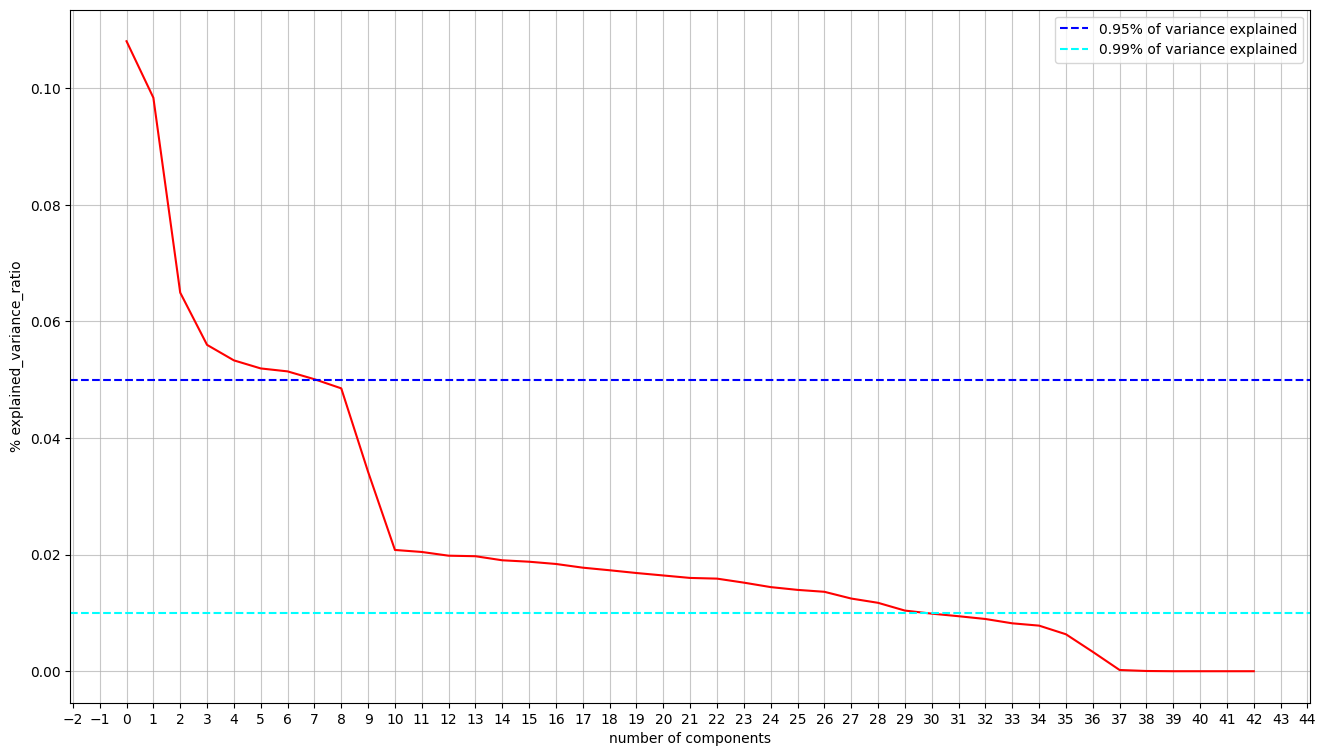

In [58]:
number_comp= Cluster_all_ohe.shape[1]
print(Cluster_all_ohe.shape)
pca= PCA(n_components=number_comp, random_state=47)
X_pca = pca.fit(Cluster_all_ohe).transform(Cluster_all_ohe)

total_variance =sum(pca.explained_variance_)
variance95= total_variance * 0.95
print(f"the total variancein our dataset is {total_variance}")
print(f"the 95% of the variance in our dataset is {variance95}")

a=zip(range(0,number_comp), pca.explained_variance_)
a= pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

plt.figure(1, figsize=(16,9))
plt.plot(pca.explained_variance_ratio_, c="r")
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.axhline(y=0.05, color='blue', linestyle='--', label='0.95% of variance explained')
plt.axhline(y=0.01, color='cyan', linestyle='--', label='0.99% of variance explained')
plt.grid(True, alpha=0.7)
plt.legend()
plt.xlabel("number of components")
plt.ylabel("% explained_variance_ratio")

## Finding Number of Clusters

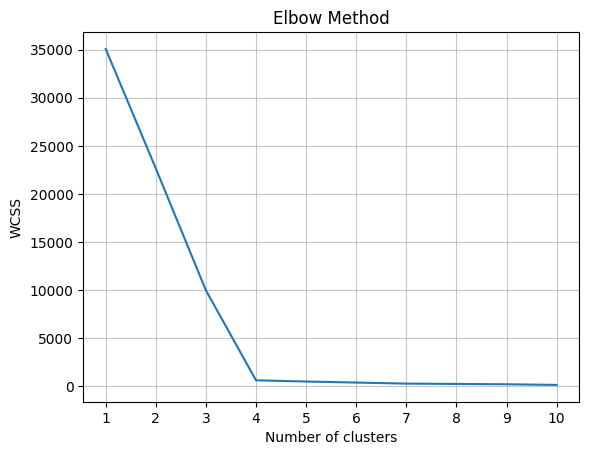

In [60]:
pca= PCA(n_components=3, random_state=47)
X_pca = pca.fit(Cluster_all_ohe).transform(Cluster_all_ohe)

wcss = []  # Within-Cluster-Sum-of-Squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.grid(True, alpha=0.7)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-Cluster-Sum-of-Squares
plt.show()

## Clustering (Hard)

In [61]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=47)
kmeans.fit(X_pca)

KMeans(n_clusters=4, random_state=47)

In [62]:
labels = kmeans.labels_

# Calculate the silhouette score for c_raw2
silhouette_score = silhouette_score(X_pca, labels)
print(f"Silhouette Score for 4 clusters: {silhouette_score}")

Silhouette Score for 4 clusters: 0.8996457213957796


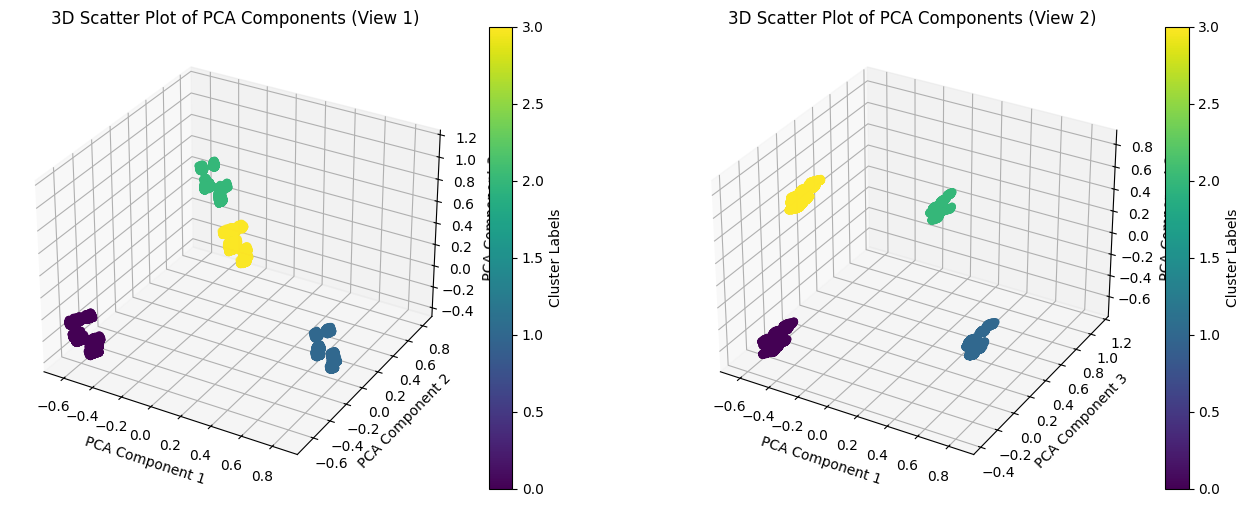

In [63]:
# Erstellen einer Figur mit zwei Subplots
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('3D Scatter Plot of PCA Components (View 1)')
colorbar1 = fig.colorbar(scatter1, ax=ax1)
colorbar1.set_label('Cluster Labels')


ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 2], X_pca[:, 1], c=labels, cmap='viridis')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 3')
ax2.set_zlabel('PCA Component 2')
ax2.set_title('3D Scatter Plot of PCA Components (View 2)')
colorbar2 = fig.colorbar(scatter2, ax=ax2)
colorbar2.set_label('Cluster Labels')

# Plot anzeigen
plt.show()

In [64]:
Cluster_all_knn = Cluster_all.copy()
Cluster_all_knn["clusters"]= labels

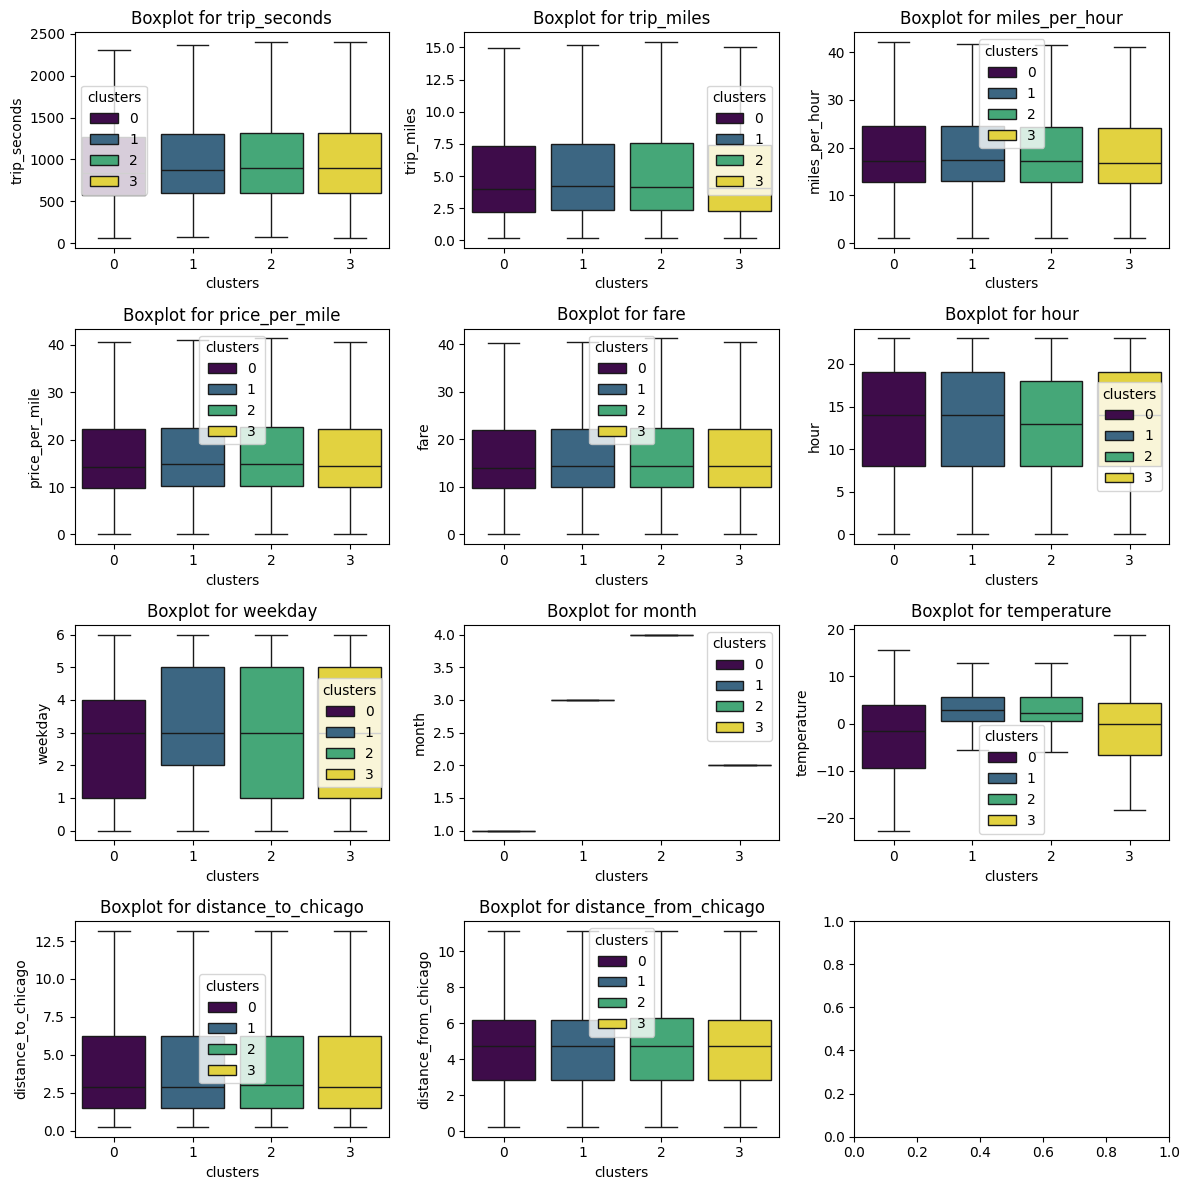

In [65]:
features_hard = ["trip_seconds", "trip_miles", "miles_per_hour", "price_per_mile", "fare", "hour", "weekday", "month","temperature", "distance_to_chicago", "distance_from_chicago"]

# Create a 3x3 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features_hard):
    
    sns.boxplot(x='clusters', y=feature, data=Cluster_all_knn, hue='clusters', palette='viridis', ax=axes[i], showfliers=False)
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {feature}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

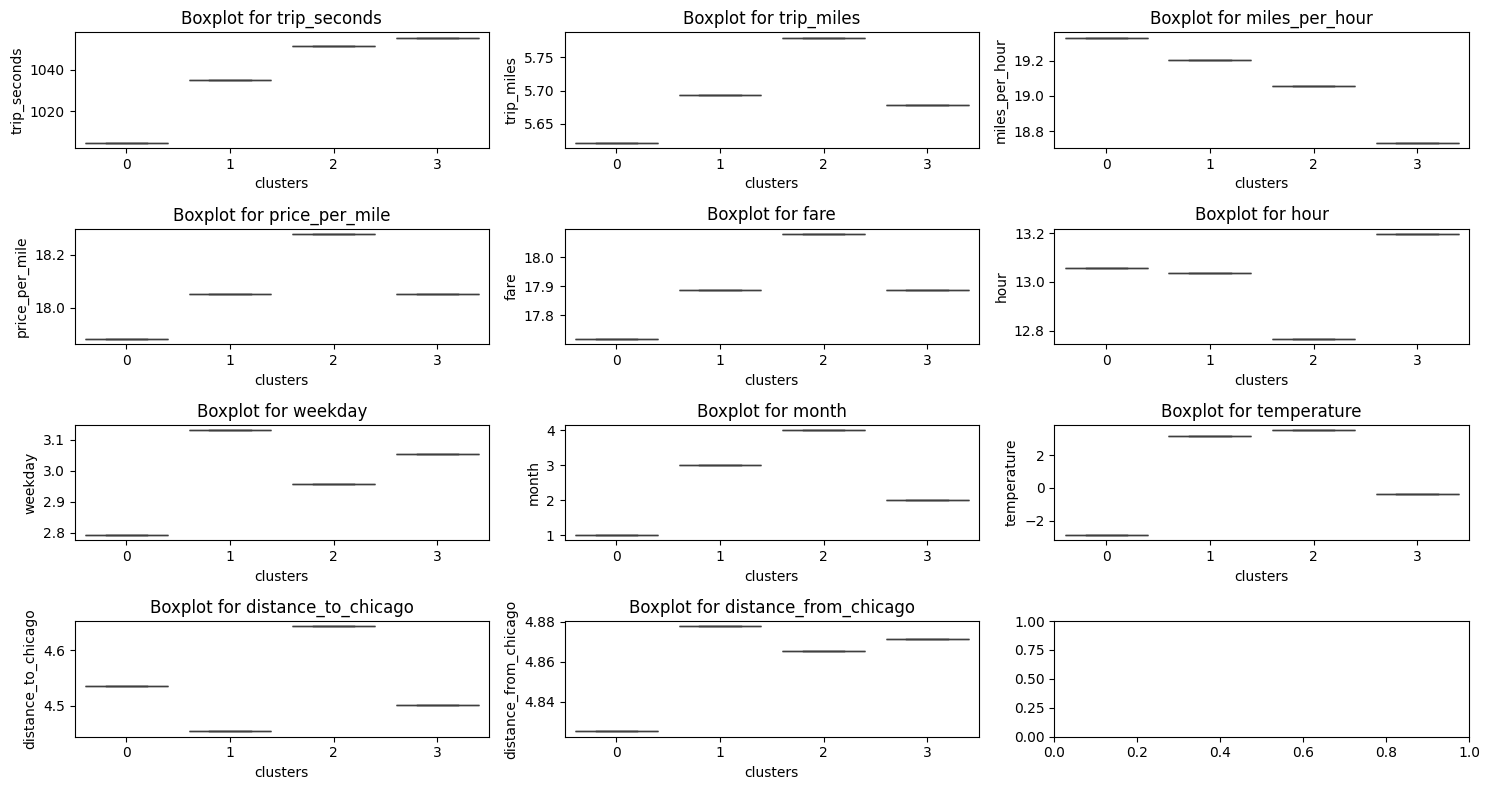

In [66]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features_hard):
    df = Cluster_all_knn[[feature, 'clusters']].groupby('clusters', as_index=False).mean()
    
    # Plot boxplot in the i-th subplot
    sns.boxplot(x='clusters', y=df.columns[1], data=df, ax=axes[i])
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {df.columns[1]}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [67]:
Cluster_all_knn[columns_to_normalize] = scaler.fit_transform(Cluster_all_knn[columns_to_normalize])

<Figure size 1600x900 with 0 Axes>

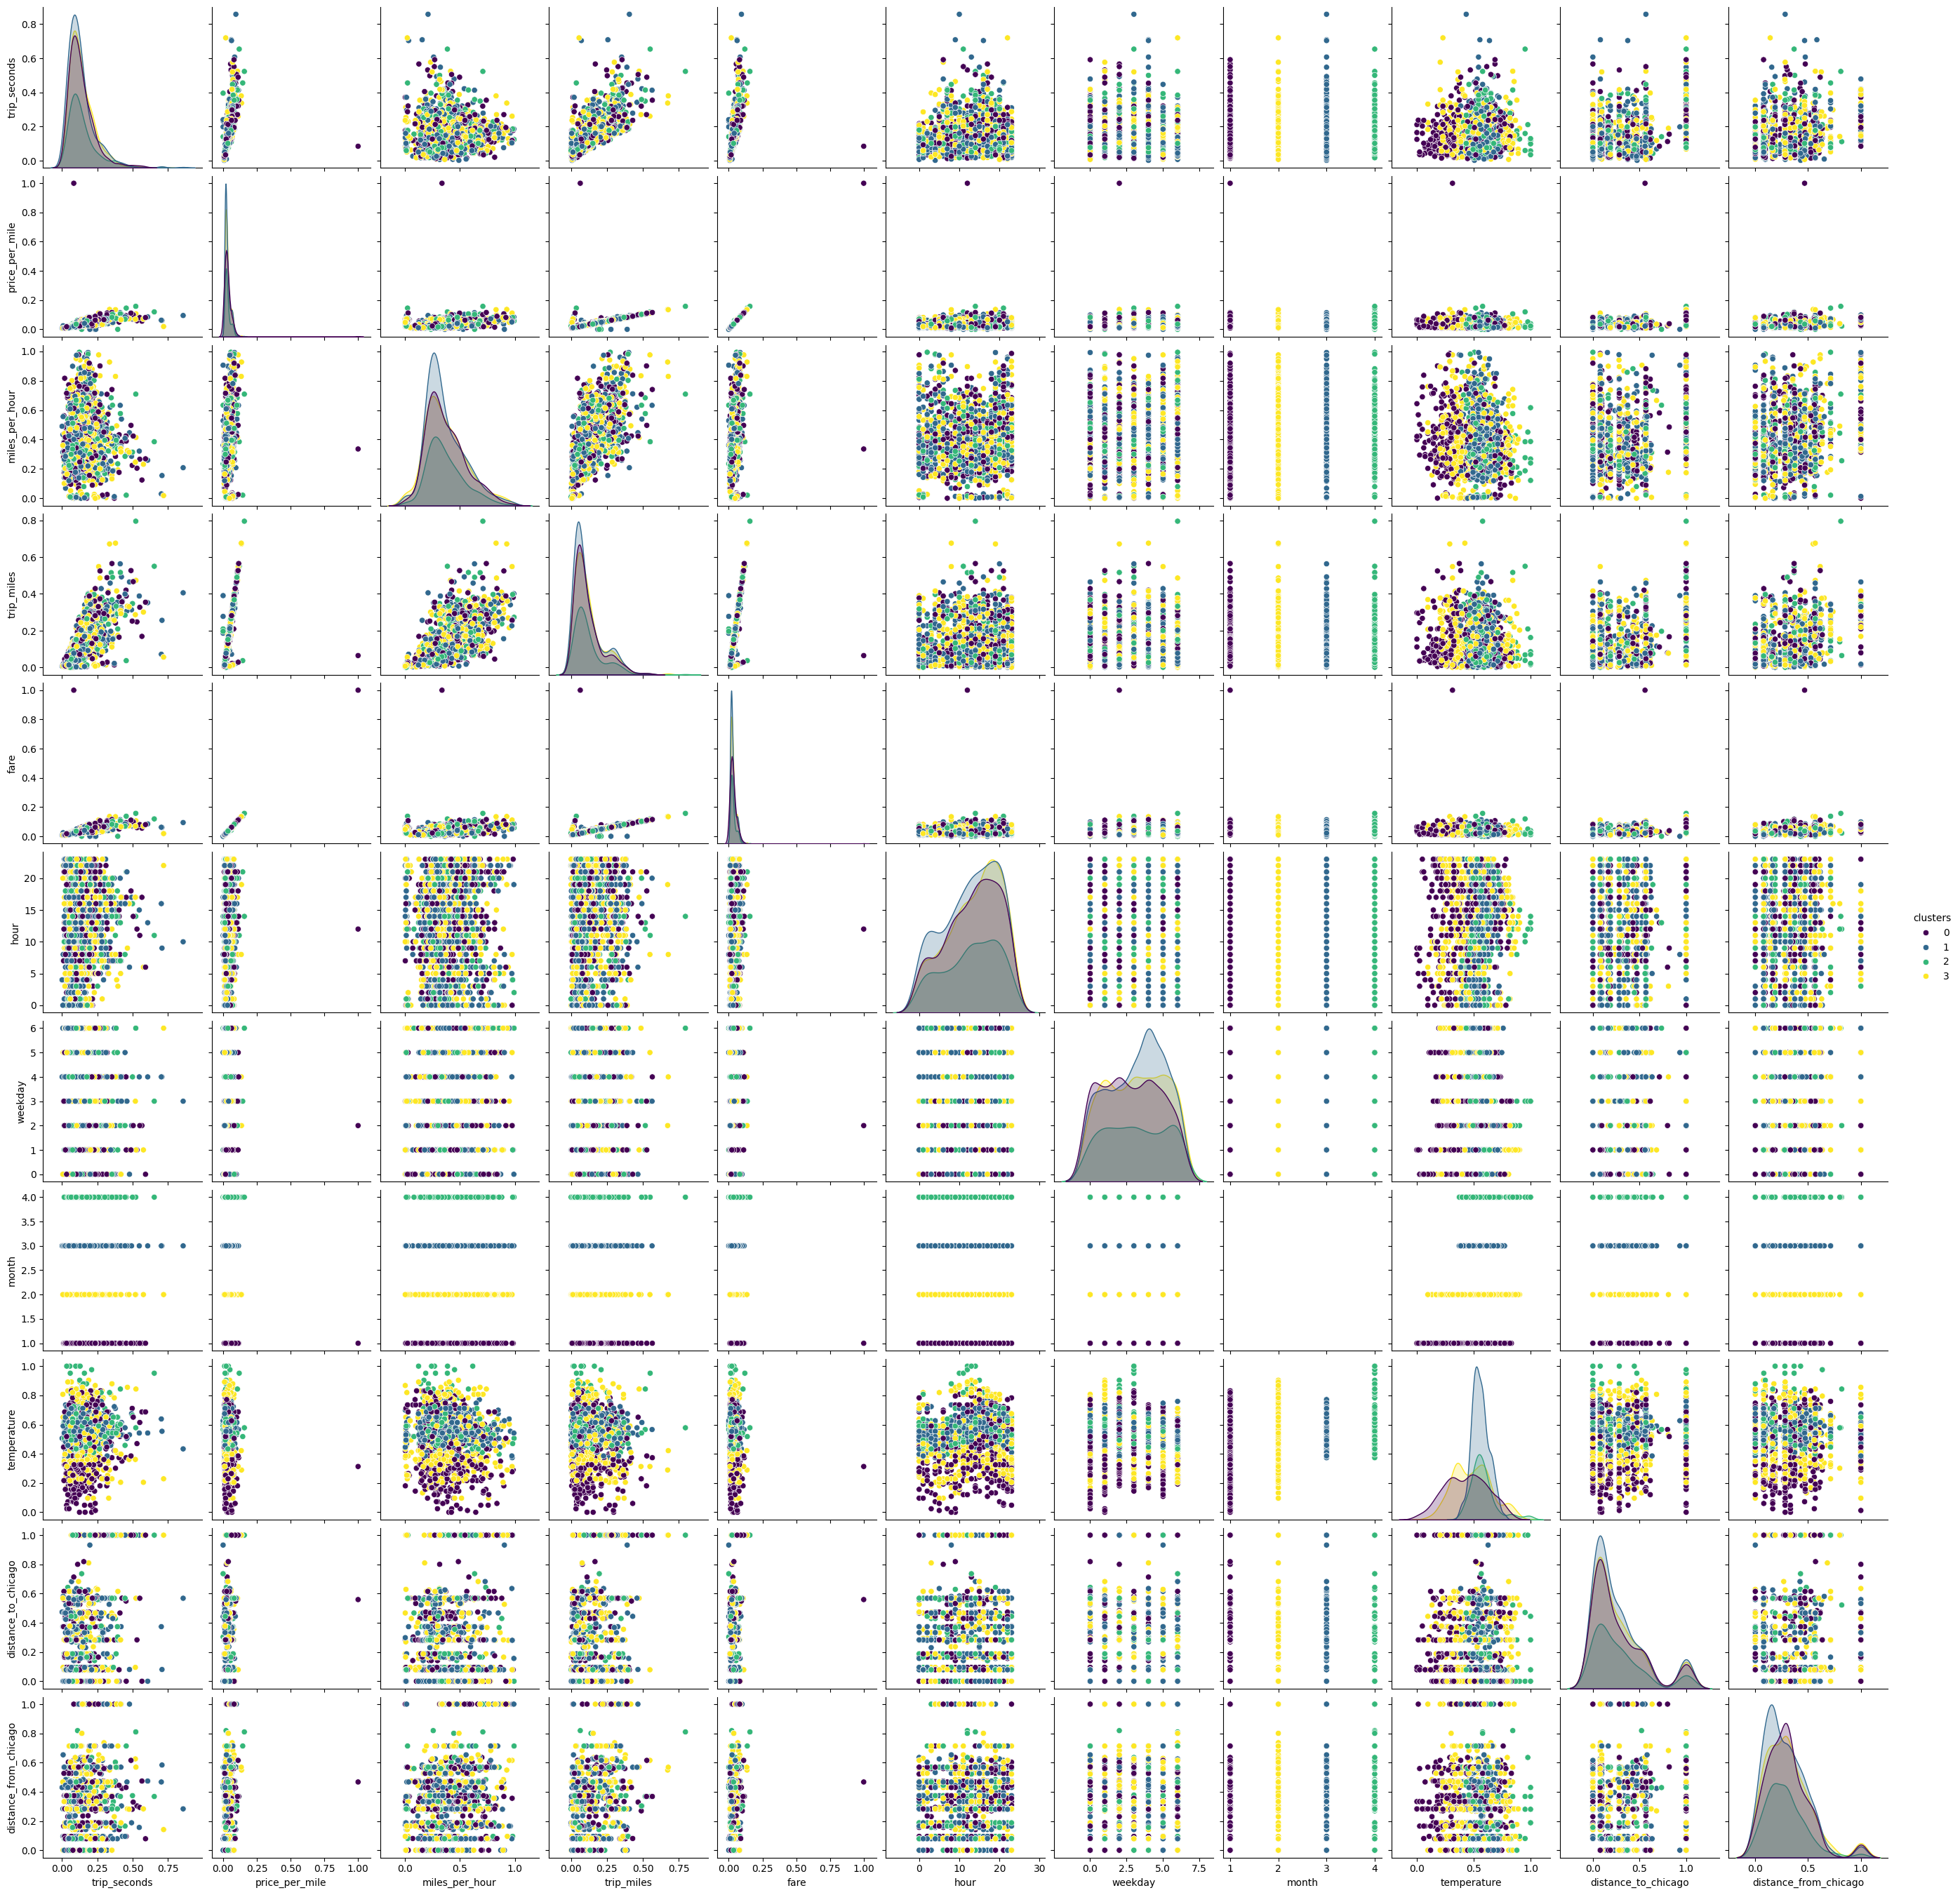

In [68]:
plt.figure(figsize=(16,9))
numerical_columns = Cluster_all_knn.columns[Cluster_all_knn.columns != "clusters"]
pairplot = sns.pairplot(Cluster_all_knn.sample(n=2000, random_state=42), hue="clusters", vars=numerical_columns, palette="viridis")

pairplot.savefig("pairplot_knn.png")

plt.show()

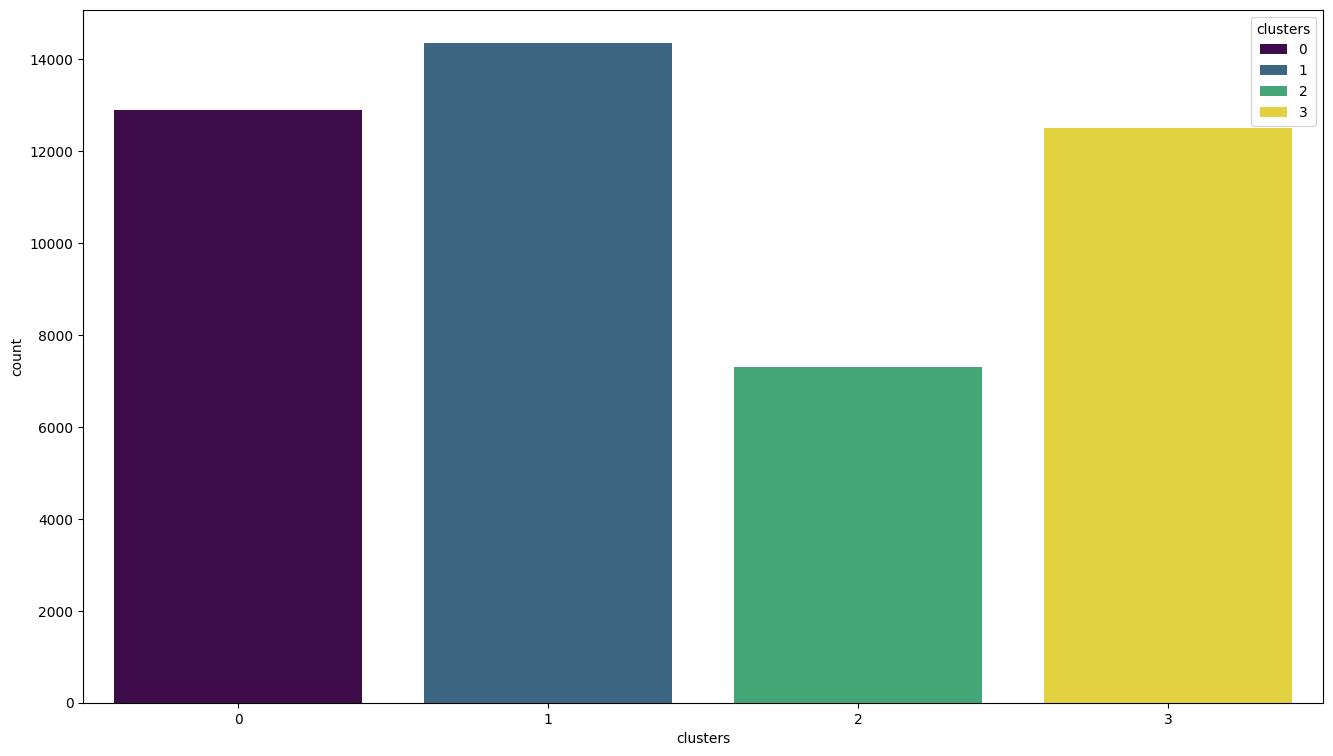

In [69]:
plt.figure(figsize=(16,9))
sns.countplot(data=Cluster_all_knn, x="clusters", hue="clusters", palette='viridis')
plt.show()

## Clustering (Soft)

In [70]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X_pca)
labels = gmm.predict(X_pca)

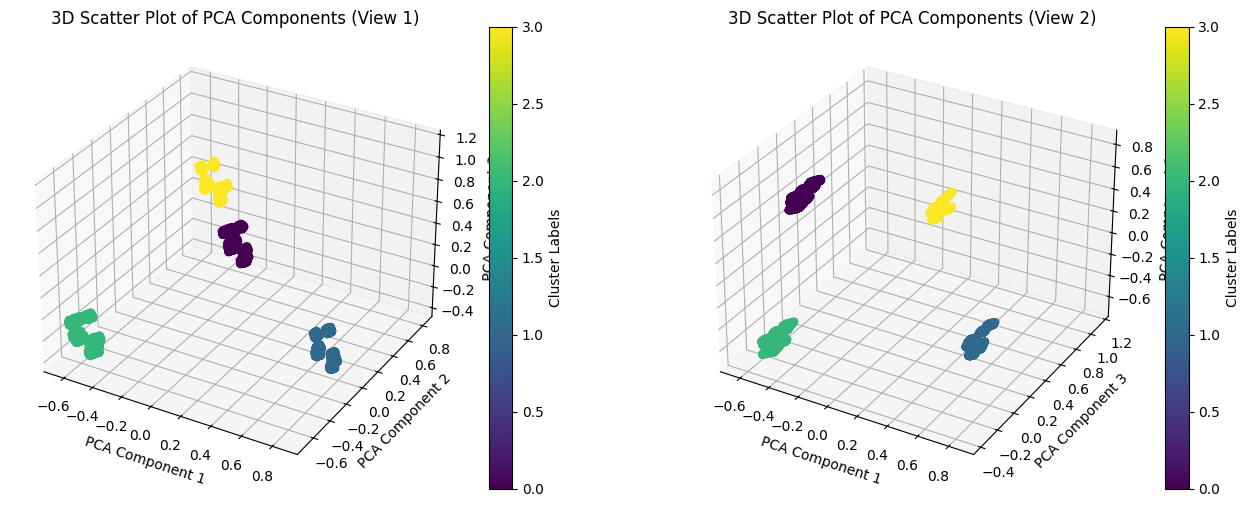

In [71]:
# Erstellen einer Figur mit zwei Subplots
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('3D Scatter Plot of PCA Components (View 1)')
colorbar1 = fig.colorbar(scatter1, ax=ax1)
colorbar1.set_label('Cluster Labels')


ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 2], X_pca[:, 1], c=labels, cmap='viridis')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 3')
ax2.set_zlabel('PCA Component 2')
ax2.set_title('3D Scatter Plot of PCA Components (View 2)')
colorbar2 = fig.colorbar(scatter2, ax=ax2)
colorbar2.set_label('Cluster Labels')

# Plot anzeigen
plt.show()

In [72]:
probs = gmm.predict_proba(X_pca)
print(probs[:5].round(3))
#print(X_pca)

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [73]:
Cluster_all_gmm = Cluster_all.copy()
Cluster_all_gmm["clusters"]= labels

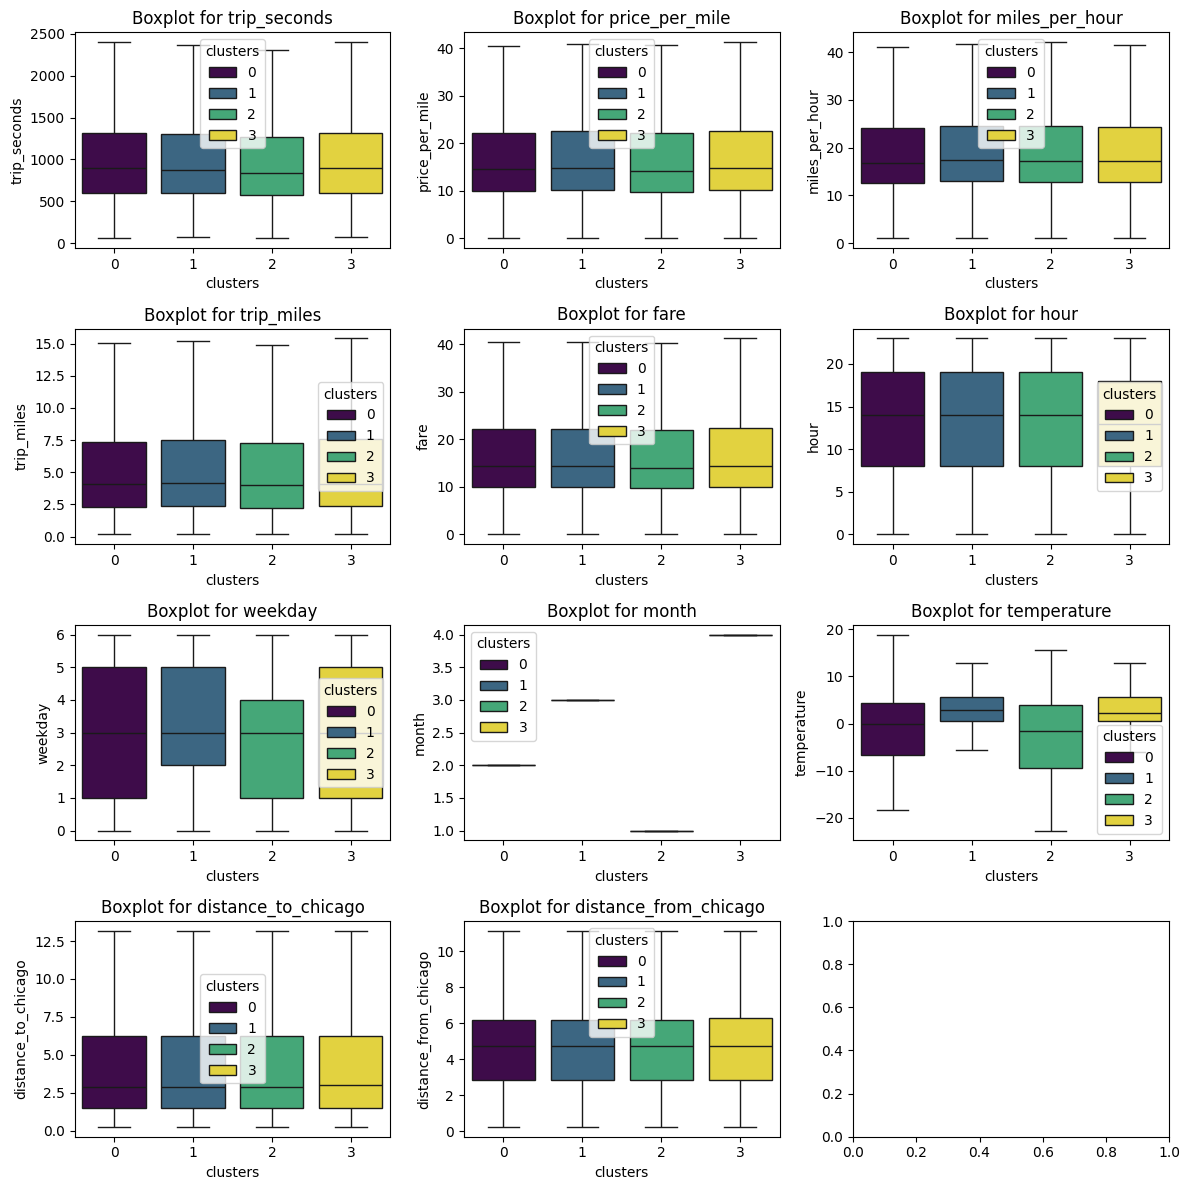

In [74]:
features_soft = ["trip_seconds", "price_per_mile", "miles_per_hour", "trip_miles", "fare", "hour", "weekday", "month","temperature", "distance_to_chicago", "distance_from_chicago"]

# Create a 3x3 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features_soft):
    
    sns.boxplot(x='clusters', y=feature, data=Cluster_all_gmm, hue='clusters', palette='viridis', ax=axes[i], showfliers=False)
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {feature}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

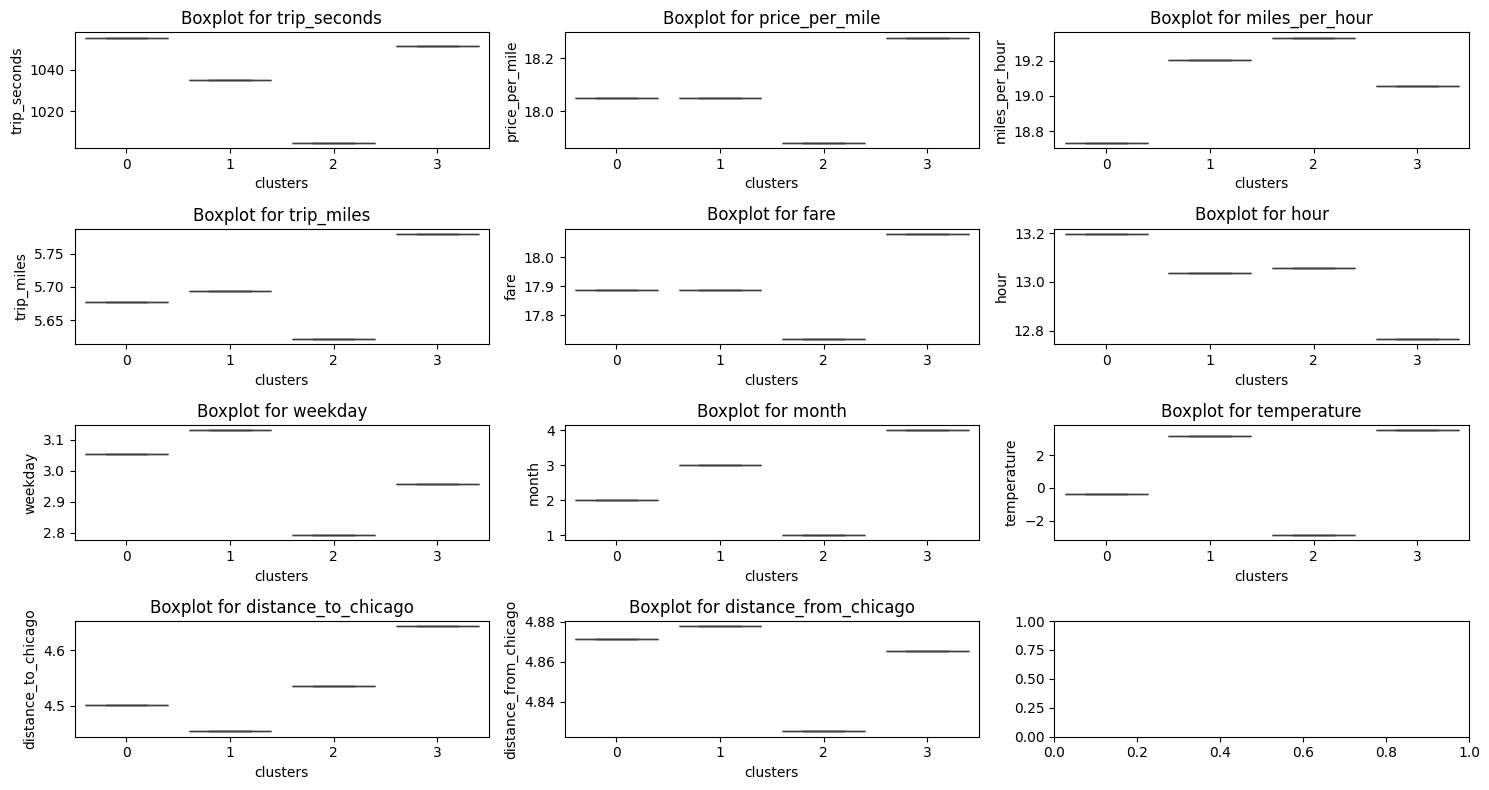

In [75]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features_soft):
    df = Cluster_all_gmm[[feature, 'clusters']].groupby('clusters', as_index=False).mean()
    
    # Plot boxplot in the i-th subplot
    sns.boxplot(x='clusters', y=df.columns[1], data=df, ax=axes[i])
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {df.columns[1]}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [76]:
Cluster_all_gmm[columns_to_normalize] = scaler.fit_transform(Cluster_all_gmm[columns_to_normalize])

<Figure size 1600x900 with 0 Axes>

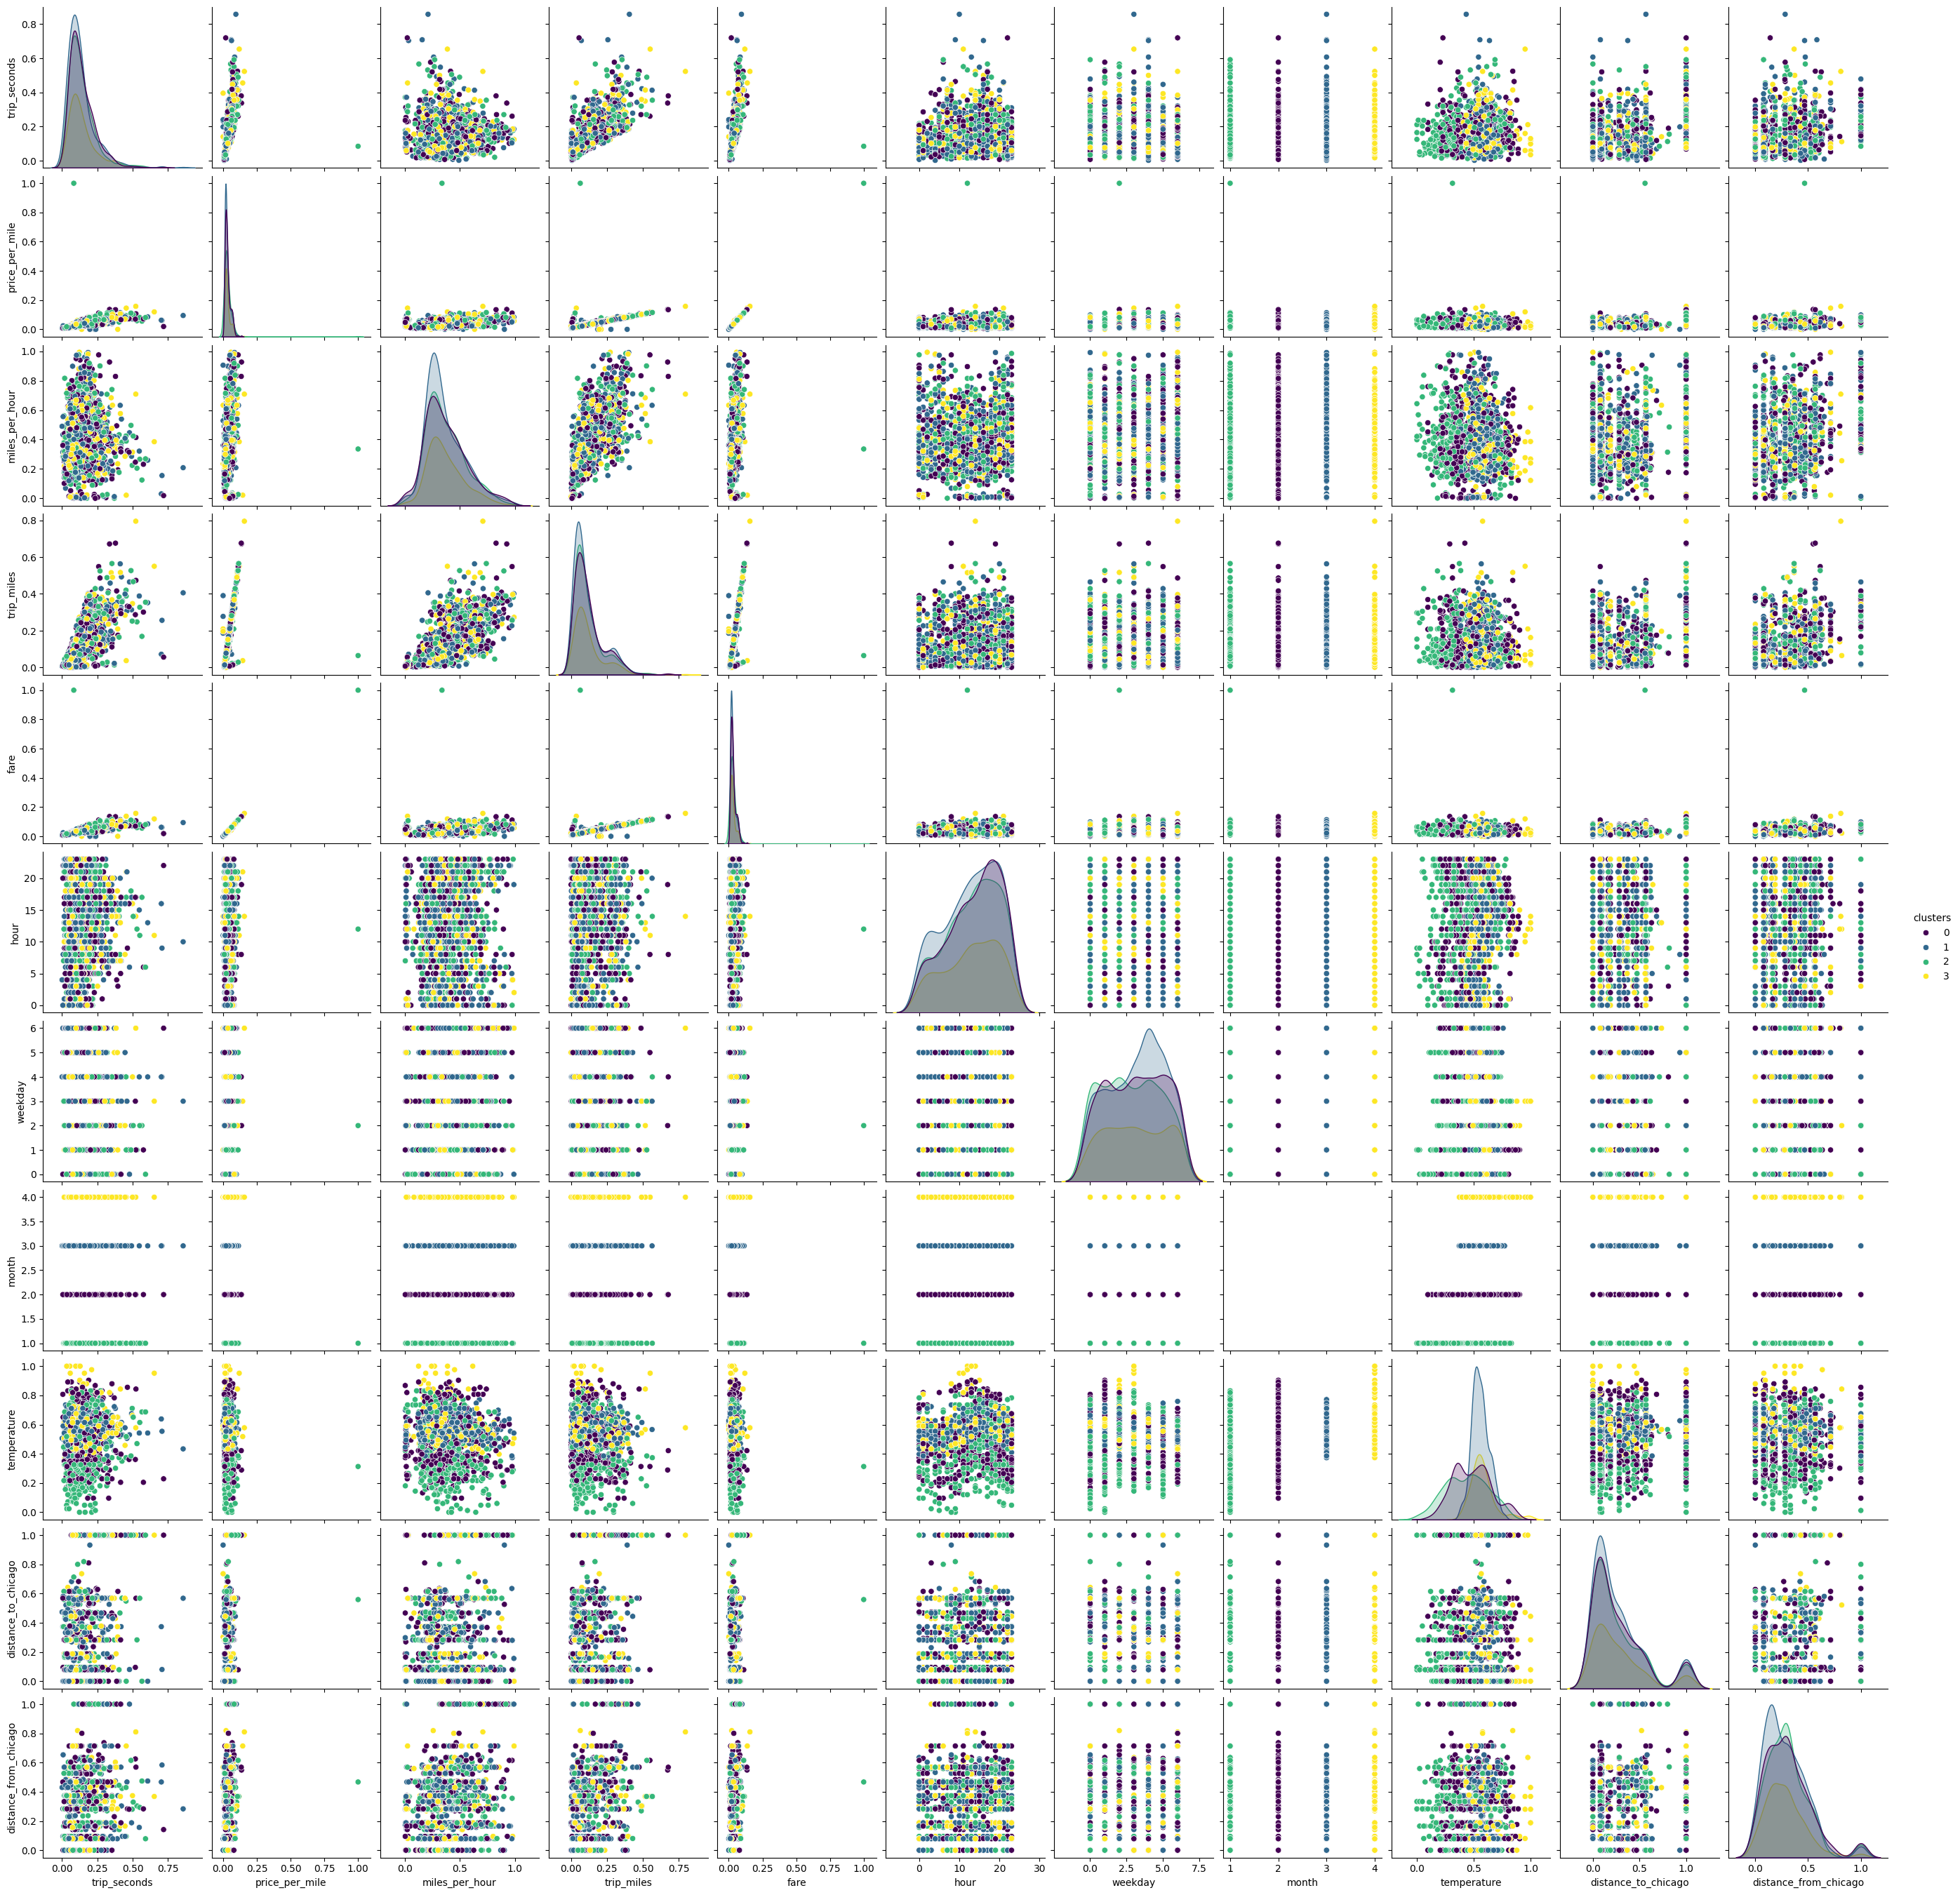

In [77]:
plt.figure(figsize=(16,9))
numerical_columns = Cluster_all_gmm.columns[Cluster_all_gmm.columns != "clusters"]
pairplot = sns.pairplot(Cluster_all_gmm.sample(n=2000, random_state=42), hue="clusters", vars=numerical_columns, palette="viridis")

pairplot.savefig("pairplot_gmm.png")

plt.show()

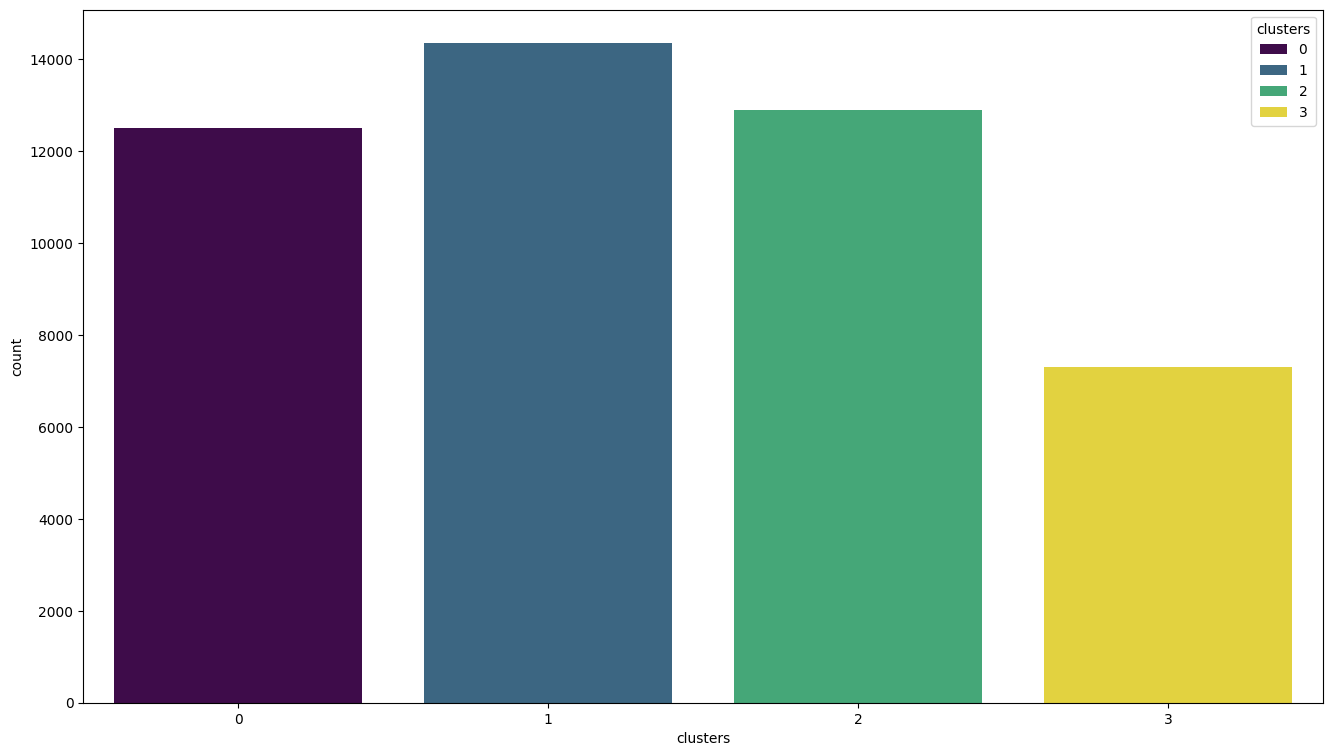

In [78]:
plt.figure(figsize=(16,9))
sns.countplot(data=Cluster_all_gmm, x="clusters", hue="clusters", palette='viridis')
plt.show()

## Spatial Kernel Density Estimation

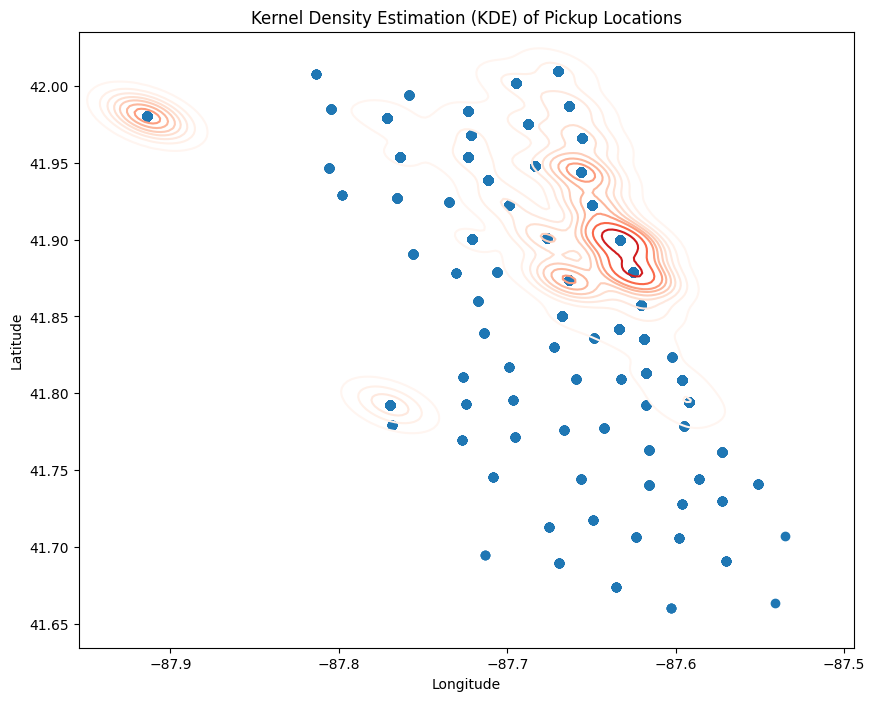

In [80]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely import wkt

bw_adjust = 1

data['geometry'] = data['pickup_centroid_location'].apply(wkt.loads)

gdf = gpd.GeoDataFrame(data, geometry='geometry')

plt.figure(figsize=(10, 8))
sns.kdeplot(x=gdf.geometry.x, y=gdf.geometry.y, cmap="Reds", bw_adjust=bw_adjust)
plt.scatter(gdf.geometry.x, gdf.geometry.y)
plt.title("Kernel Density Estimation (KDE) of Pickup Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

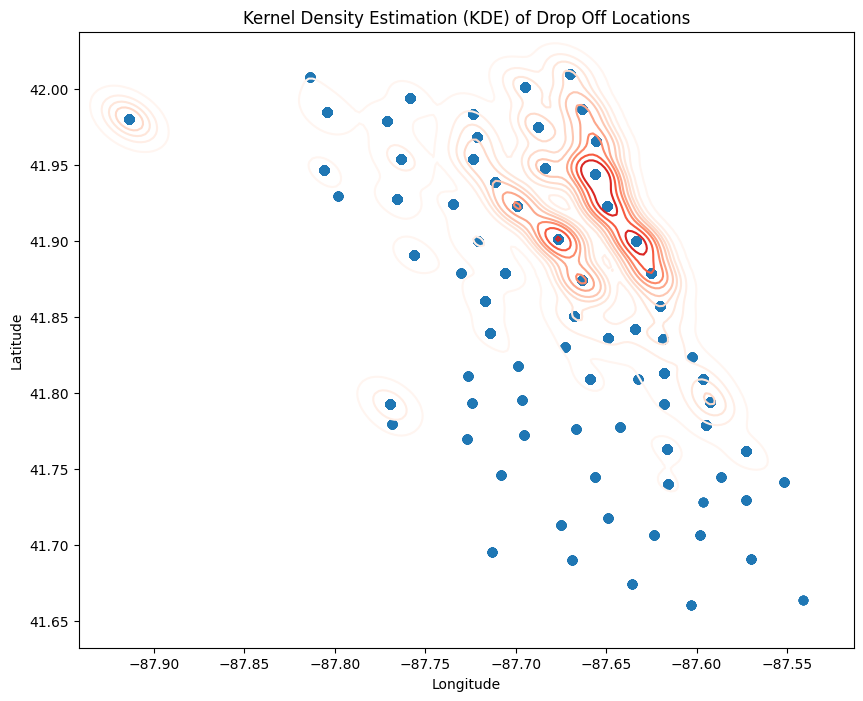

In [81]:
data['geometry'] = data['dropoff_centroid_location'].apply(wkt.loads)

gdf = gpd.GeoDataFrame(data, geometry='geometry')

plt.figure(figsize=(10, 8))
sns.kdeplot(x=gdf.geometry.x, y=gdf.geometry.y, cmap="Reds", bw_adjust=bw_adjust)
plt.scatter(gdf.geometry.x, gdf.geometry.y)
plt.title("Kernel Density Estimation (KDE) of Drop Off Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Comparison

Cluster-Zuweisung vergleichen
Qualität vergleichen
Anzahl (anders) klassifizierte Punkte ausrechnen
Countplot nebeneinander legen